<a href="https://colab.research.google.com/github/urrvisharma/NLP-Wine-and-Food-Pairings/blob/main/340FinalProjectFile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers datasets sentence-transformers faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 42.8 MB/s eta 0:00:00


### Importing

In [ ]:
import pandas as pd
import numpy as np
import re
from collections import Counter

from transformers import BertTokenizerFast, BertForMaskedLM, TrainingArguments, Trainer
from datasets import Dataset

from sentence_transformers import SentenceTransformer, models

import faiss
from numpy.linalg import norm


In [ ]:
# Wine dataset
wine = pd.read_csv('/content/winemag-data-130k-v2.csv')
wine = wine.reset_index(drop=True)

# Recipe dataset
recipes = pd.read_csv('/content/Food Ingredients and Recipe Dataset with Image Name Mapping.csv')
recipes = recipes.dropna(subset=['Ingredients']).reset_index(drop=True)


## Text cleaning

In [ ]:
MEASUREMENT_WORDS = [
    'cup', 'cups', 'quart', 'quarts', 'pint', 'pints', 'gallon', 'gallons',
    'ounce', 'ounces', 'oz', 'pound', 'pounds', 'lb', 'lbs',
    'tablespoon', 'tablespoons', 'tbsp', 'tbsps',
    'teaspoon', 'teaspoons', 'tsp', 'tsps',
    'ml', 'milliliter', 'milliliters',
    'liter', 'liters', 'l',
    'gram', 'grams', 'g', 'kg', 'kilogram', 'kilograms'
] #Used ai to write potential measurement words that should be removed

def clean_text_basic(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r'\d+', ' ', text)             # remove numbers
    text = re.sub(r'[^a-z\s]', ' ', text)        # keep only letters & spaces
    text = re.sub(r'\s+', ' ', text).strip()     # normalize spaces
    return text

def remove_measurements(text: str) -> str:
    for w in MEASUREMENT_WORDS:
        text = re.sub(rf'\b{w}\b', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


wine['clean_description'] = wine['description'].apply(clean_text_basic)

# Ingredients: turn list/string into clean text
def ingredients_to_text(ing):
    if isinstance(ing, list):
        return ' '.join(ing)
    return str(ing)

recipes['raw_ingredients_text'] = recipes['Ingredients'].apply(ingredients_to_text)
recipes['clean_ingredients'] = recipes['raw_ingredients_text'].apply(clean_text_basic)
recipes['clean_ingredients'] = recipes['clean_ingredients'].apply(remove_measurements)


## Augmentation
*   not necessary but will help improve model accuracy




In [ ]:
FLAVOR_DICT = {
    'lemon': ['acidic', 'bright', 'citrus'],
    'lime': ['acidic', 'citrus'],
    'vinegar': ['acidic', 'sharp'],
    'tomato': ['acidic', 'umami'],
    'cream': ['creamy', 'fatty', 'rich'],
    'milk': ['creamy', 'rich'],
    'butter': ['buttery', 'rich', 'fatty'],
    'cheese': ['creamy', 'salty', 'fatty'],
    'mushroom': ['earthy', 'umami'],
    'soy': ['umami', 'salty'],
    'soy sauce': ['umami', 'salty'],
    'miso': ['umami'],
    'beef': ['meaty', 'rich'],
    'pork': ['meaty', 'fatty'],
    'chicken': ['savory', 'light'],
    'salmon': ['oily', 'fishy'],
    'tuna': ['fishy'],
    'garlic': ['pungent', 'savory'],
    'onion': ['pungent', 'sweet'],
    'honey': ['sweet'],
    'sugar': ['sweet'],
    'chili': ['spicy', 'hot'],
    'pepper': ['spicy', 'pungent'],
    'basil': ['herbal'],
    'thyme': ['herbal'],
    'rosemary': ['herbal'],
    'smoked': ['smoky'],
    'grilled': ['smoky']
} #used AI to help create the flavor dictionary

def augment_with_flavors(text: str) -> str:
    out = text
    for ingr, flavors in FLAVOR_DICT.items():
        if ingr in text:
            out += ' ' + ' '.join(flavors)
    return out

recipes['aug_ingredients'] = recipes['clean_ingredients'].apply(augment_with_flavors)


### Creates one giant list of the ingredients and wine pairings

In [ ]:
corpus_texts = []

# wine descriptions
corpus_texts += wine['clean_description'].tolist()

# recipes (use augmented ingredients text)
corpus_texts += recipes['aug_ingredients'].tolist()

# make a HuggingFace Dataset
corpus_ds = Dataset.from_dict({"text": corpus_texts})
len(corpus_ds)


143472

### Turns each sentence into token ids

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=128,
        padding="max_length"
    )

tokenized = corpus_ds.map(tokenize_fn, batched=True, remove_columns=["text"])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/143472 [00:00<?, ? examples/s]

### Masking words to predict
*   By predicting masked flavor items, Bert learns to understand acidity, fattiness, earthiness, etc...




In [ ]:
def add_labels(batch):
    batch["labels"] = batch["input_ids"].copy()
    return batch

mlm_dataset = tokenized.map(add_labels, batched=True)


Map:   0%|          | 0/143472 [00:00<?, ? examples/s]

### Training Bert model on our corpus (wine and food descriptions)
*   Makes model specialized for food and wine words

### Don't run again (unless to improve training)
*   Model is saved in Google Drive and can be called on







In [ ]:
import os

os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
os.environ["WANDB_SILENT"] = "true"

mlm_dataset_small = mlm_dataset.shuffle(seed=42).select(range(20000))

model_mlm = BertForMaskedLM.from_pretrained("bert-base-uncased")

training_args = TrainingArguments(
    output_dir="/content/bert_flavor_domain",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=500,
    save_steps=5000,
    save_total_limit=2,
)

trainer = Trainer(
    model=model_mlm,
    args=training_args,
    train_dataset=mlm_dataset_small,
)

trainer.train()

model_mlm.save_pretrained("/content/bert_flavor_domain")
tokenizer.save_pretrained("/content/bert_flavor_domain")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is 

Step,Training Loss
500,0.129500


('/content/bert_flavor_domain/tokenizer_config.json',
 '/content/bert_flavor_domain/special_tokens_map.json',
 '/content/bert_flavor_domain/vocab.txt',
 '/content/bert_flavor_domain/added_tokens.json',
 '/content/bert_flavor_domain/tokenizer.json')

### Loading Model w/o retraining

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = "/content/drive/MyDrive/340_Project/bert_flavor_domain"

from transformers import BertForMaskedLM, BertTokenizer

tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForMaskedLM.from_pretrained(model_path)

print("Loaded fine-tuned flavor-domain BERT")


Loaded fine-tuned flavor-domain BERT


### Wrap into sentence transformer
*   So that the wine and recipe embeddings can be fixed lengths for comparison




In [ ]:
from sentence_transformers import SentenceTransformer, models

model_path = "/content/drive/MyDrive/340_Project/bert_flavor_domain"

word_embedding_model = models.Transformer(model_path)
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True
)

bert_pair_encoder = SentenceTransformer(modules=[word_embedding_model, pooling_model])


Some weights of BertModel were not initialized from the model checkpoint at /content/drive/MyDrive/340_Project/bert_flavor_domain and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Computes embeddings



*   Again, don't run. It is saved to drive already, just run the np.load cell right below it




In [ ]:
# Convert to lists of strings
wine_texts = wine['clean_description'].tolist()
recipe_texts = recipes['aug_ingredients'].tolist()

# Encode
wine_emb = bert_pair_encoder.encode(
    wine_texts,
    batch_size=64,
    show_progress_bar=True,
    normalize_embeddings=True
)

recipe_emb = bert_pair_encoder.encode(
    recipe_texts,
    batch_size=64,
    show_progress_bar=True,
    normalize_embeddings=True
)

# Store in DataFrames for convenience
wine['bert_emb'] = list(wine_emb)
recipes['bert_emb'] = list(recipe_emb)


Batches:   0%|          | 0/1788 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
wine_emb = np.load('/content/drive/MyDrive/340_Project/wine_emb.npy')
recipe_emb = np.load('/content/drive/MyDrive/340_Project/recipe_emb.npy')

wine['bert_emb'] = list(wine_emb)
recipes['bert_emb'] = list(recipe_emb)


In [ ]:
dim = wine_emb.shape[1]
index = faiss.IndexFlatIP(dim)   # inner product
index.add(np.array(wine_emb).astype('float32'))

print("Indexed wines:", index.ntotal)

Indexed wines: 129971


###Multi-label Classfier

*   outputs a vector of probabilities for wines and foods for each flavor profile


In [ ]:
import tensorflow
from tensorflow import keras

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split

FLAVORS = {
    'weight': ['light','medium','heavy','full-bodied','full bodied','fullbodied'],
    'acid':   ['acidic','acid','bright','tart','citrus','lemon','lime','zesty'],
    'sweet':  ['sweet','honey','sugary','dessert','jammy','caramel'],
    'tannin': ['tannin','tannic','astringent','dry','grippy'],
    'salty':  ['salt','salty','soy','parmesan'],
    'spicy':  ['spicy','chili','pepper','cayenne','hot'],
    'umami':  ['umami','savory','miso','soy','mushroom','broth'],
    'creamy': ['creamy','buttery','butter','cream','rich']
} #Used ai to create the flavors here

def text_to_tags(text):
    text = text.lower()
    tags = []
    for f, words in FLAVORS.items():
        if any(w in text for w in words):
            tags.append(f)
    return tags

recipes["tags"] = recipes["aug_ingredients"].apply(text_to_tags)
wine["tags"] = wine["clean_description"].apply(text_to_tags)


mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(recipes["tags"])   # training labels for the classifier

X = np.vstack(recipes["bert_emb"].values) #building feature label for BERT embeddings

#training classifer
def build_flavor_model(input_dim, num_labels):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(512, activation='relu')(inp)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(num_labels, activation='sigmoid')(x)
    model = models.Model(inp, out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

input_dim = X.shape[1]
num_labels = Y.shape[1]

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1)


clf = build_flavor_model(input_dim, num_labels)
es = callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = clf.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=8,
    batch_size=512,
    callbacks=[es],
    verbose=1
)


clf.fit(X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=8, batch_size=512, callbacks=[es])

# Recipes
recipes_emb = np.vstack(recipes["bert_emb"].values)
recipes_probs = clf.predict(recipes_emb)
for i, c in enumerate(mlb.classes_):
    recipes[c] = recipes_probs[:, i]

# Wines
wine_emb_mat = np.vstack(wine["bert_emb"].values)
wine_probs = clf.predict(wine_emb_mat)
for i, c in enumerate(mlb.classes_):
    wine[c] = wine_probs[:, i]

print("Flavor prediction columns added:", mlb.classes_)

Epoch 1/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - AUC: 0.6941 - loss: 0.6386 - val_AUC: 0.8277 - val_loss: 0.5456
Epoch 2/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - AUC: 0.8349 - loss: 0.5177 - val_AUC: 0.8827 - val_loss: 0.4323
Epoch 3/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - AUC: 0.8841 - loss: 0.4286 - val_AUC: 0.9079 - val_loss: 0.3892
Epoch 4/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - AUC: 0.9057 - loss: 0.3905 - val_AUC: 0.9227 - val_loss: 0.3590
Epoch 5/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - AUC: 0.9202 - loss: 0.3615 - val_AUC: 0.9364 - val_loss: 0.3308
Epoch 6/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - AUC: 0.9336 - loss: 0.3321 - val_AUC: 0.9475 - val_loss: 0.2999
Epoch 7/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - AUC: 0.9438 - loss: 0.3068 - val_AUC: 0.9556 - val_loss: 0.2788
Epoch 8/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - AUC: 0.9528 - loss: 0.2817 - val_AUC: 0.9619 - val_loss: 0.2580
Epoch 1/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - AUC: 0.9580 - loss: 

### Plotting How Well The Model Did Over Time

In [ ]:
print(history.history.keys())


dict_keys(['AUC', 'loss', 'val_AUC', 'val_loss'])


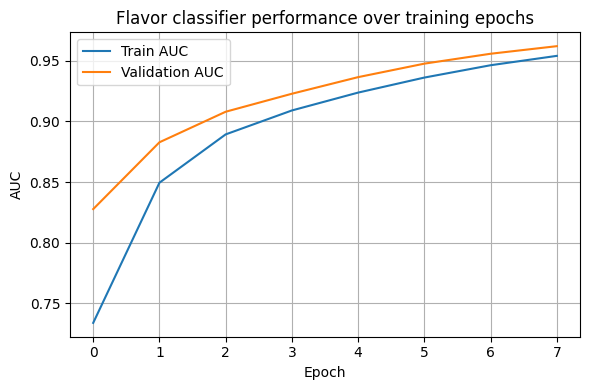

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

plt.plot(history.history['AUC'],     label='Train AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')

plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Flavor classifier performance over training epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Creating rule based scoring based on wine and food pairing rules

In [ ]:
# def cosine_sim(a, b):
#     a = np.array(a); b = np.array(b)
#     if norm(a) == 0 or norm(b) == 0:
#         return 0.0
#     return float(np.dot(a, b) / (norm(a) * norm(b)))

# weights that can be tweaked
RULE_WEIGHTS = {
    'acid_cream_bonus': 0.3,
    'umami_bonus': 0.2,
    'sweet_spice_bonus': 0.3,
    'tannin_umami_penalty': 0.3,
    'salt_tannin_penalty': 0.3,
    'acid_penalty': 0.4,
    'weight_penalty': 0.4
}


# Used AI and Wine folly to come up with a rule based pairing system for food and wine
def rule_score(food_vec: dict, wine_vec: dict) -> float:
    score = 0.0

    # 1. Cream/fat food + acidic wine -> bonus
    score += RULE_WEIGHTS['acid_cream_bonus'] * (food_vec['creamy'] * wine_vec['acid'])

    # 2. Earthy/umami alignment -> bonus
    score += RULE_WEIGHTS['umami_bonus'] * (food_vec['umami'] * wine_vec['umami'])

    # 3. Spicy food + sweet wine -> bonus
    score += RULE_WEIGHTS['sweet_spice_bonus'] * (food_vec['spicy'] * wine_vec['sweet'])

    # 4. Umami food + tannic wine -> penalty
    score -= RULE_WEIGHTS['tannin_umami_penalty'] * (food_vec['umami'] * wine_vec['tannin'])

    # 5. Food more acidic than wine -> penalty
    if food_vec['acid'] > wine_vec['acid']:
        score -= RULE_WEIGHTS['acid_penalty'] * (food_vec['acid'] - wine_vec['acid'])

    # 6. Weight mismatch -> penalty
    score -= RULE_WEIGHTS["weight_penalty"] * (1 - abs(food_vec["weight"] - wine_vec["weight"]))

    # 7. Salt and tannin -> penalty
    score -= RULE_WEIGHTS['salt_tannin_penalty'] * (food_vec['salty'] * wine_vec['tannin'])

    return score

In [ ]:
def recommend_wines_for_recipe(recipe_idx: int, k_candidates=200, k_final=5):

    r_emb = np.array(recipes.loc[recipe_idx, 'bert_emb'], dtype='float32').reshape(1, -1) # pullrecipe embedding

    D, I = index.search(r_emb, k_candidates) #bert (faiss) similarity
    I = I[0]

    food_vec = {c: float(recipes.loc[recipe_idx][c]) for c in mlb.classes_} #build recipe flavor vector from nn output

    results = []
    for wine_idx in I:
        wine_vec = {c: float(wine.loc[wine_idx, c]) for c in mlb.classes_} #building wine flavor vector

        rscore = rule_score(food_vec, wine_vec) #we only care about rule based scoring

        results.append({
            'wine_index': wine_idx,
            'rule_score': rscore
        })

    raw = np.array([r['rule_score'] for r in results]) #normalizing the rule based results
    min_s, max_s = raw.min(), raw.max()

    if max_s > min_s:
        norm = (raw - min_s) / (max_s - min_s)
    else:
        norm = np.ones_like(raw)

    for r, s in zip(results, norm):
        r['final_score'] = float(s)

    results = sorted(results, key=lambda x: x['final_score'], reverse=True) #return top k wines
    return results[:k_final]


In [ ]:
# Pick a recipe index to inspect
recipe_idx = 6748  # change this to test different recipes

print("RECIPE", recipe_idx)
print("TITLE:", recipes.loc[recipe_idx, 'Title'])
print()

top_recs = recommend_wines_for_recipe( #getting top 5 win recs based on the pairing rules
    recipe_idx,
    k_final=5
)

for rank, rec in enumerate(top_recs, start=1):
    wi = rec['wine_index']
    row = wine.loc[wi]

    print(
        f"Rank {rank} | Score: {rec['final_score']:.3f} "
        f"(rule_score={rec['rule_score']:.3f})"
    )
    print(f"Wine: {row['title']} | Variety: {row['variety']} | Country: {row['country']}")
    print(f"Description: {row['description']}")
    print("-" * 80)


RECIPE 6748
TITLE: The Fluffiest Mashed Potatoes

Rank 1 | Score: 1.000 (rule_score=0.112)
Wine: Sanford 2011 La Rinconada Vineyard Chardonnay (Sta. Rita Hills) | Variety: Chardonnay | Country: US
Description: This wine doesn't hold back from the representative California-style on its rich and strong nose: candied apples, browned butter, vanilla candies, sea salt caramel, browned marshmallow, even some Olroso Sherry tones. Yet the palate brings it all into focus, with bitter peach skin, pithy lime and grippy apricot playing the foil to vanilla bean and butter. It's a bold yet expertly restrained wine.
--------------------------------------------------------------------------------
Rank 2 | Score: 0.958 (rule_score=0.091)
Wine: Kuentz-Bas 2008 Collection Muscat (Alsace) | Variety: Muscat | Country: France
Description: Pale lemon with green hints. Subtle nose showing more savory herbal aromas, fresh cut nettles and a spicy balsamic note. Opened up on the palate  with lots of bright cream

In [ ]:
# 1. Define radar plot function
import matplotlib.pyplot as plt

labels = list(FLAVORS.keys())

def plot_flavor_radar(recipe_row, wine_row, labels):
    values_recipe = [recipe_row[l] for l in labels]
    values_wine   = [wine_row[l] for l in labels]

    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    values_recipe += values_recipe[:1]
    values_wine   += values_wine[:1]
    angles        += angles[:1]

    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

    ax.plot(angles, values_recipe, label="Recipe", linewidth=2)
    ax.fill(angles, values_recipe, alpha=0.2)

    ax.plot(angles, values_wine, label="Wine", linewidth=2)
    ax.fill(angles, values_wine, alpha=0.2)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_yticklabels([])
    ax.legend(loc="upper right", bbox_to_anchor=(1.1,1.1))
    plt.show()

#AI helped in creating the radar plot

Recipe: The Fluffiest Mashed Potatoes
Top Wine: Sanford 2011 La Rinconada Vineyard Chardonnay (Sta. Rita Hills)



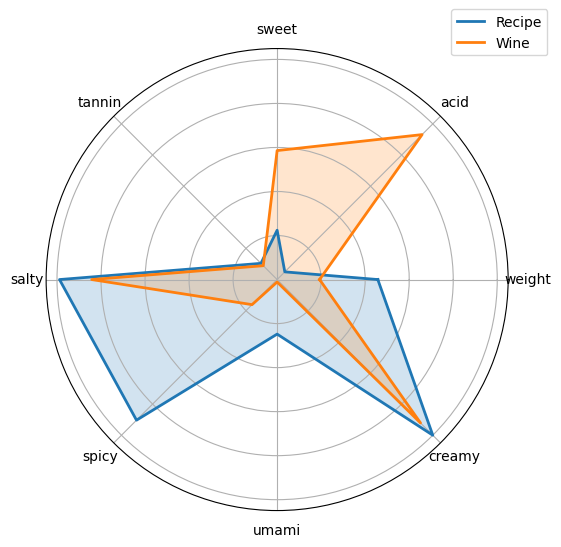

In [ ]:
recipe_row = recipes.loc[recipe_idx]


top_rec = recommend_wines_for_recipe(recipe_idx, k_final=1)[0]
wine_idx = top_rec['wine_index']
wine_row = wine.loc[wine_idx]

print("Recipe:", recipe_row['Title'])
print("Top Wine:", wine_row['title'])
print()


plot_flavor_radar(recipe_row, wine_row, labels)
